Emotion classification
================

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from src.classifiers.classification_cnn import ClassificationCNN
from src.data_utils import get_CIFAR10_datasets, OverfitSampler, rel_error

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset
=========
Preprocessing will be needed

In [15]:
# Load the (preprocessed) CIFAR10 data. The preprocessing includes
# channel swapping, normalization and train-val-test splitting.
# Loading the datasets might take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_datasets()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Examples
------------------

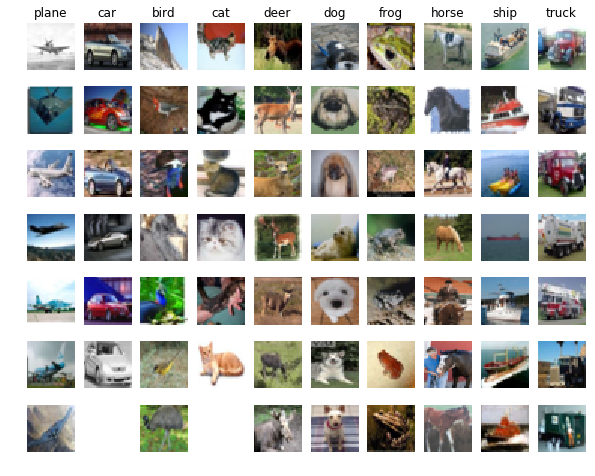

In [16]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for cls_idx, cls in enumerate(classes):
    cls_data = [datum for datum in test_data if datum[1] == cls_idx]
    rnd_idxs = np.random.randint(0, len(cls_data), samples_per_class)
    rnd_cls_data = [datum for i, datum in enumerate(cls_data) if i in rnd_idxs]
    for i, cls_datum in enumerate(rnd_cls_data):
        plt_idx = i * num_classes + cls_idx + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(cls_datum[0].numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Training the Network

In [17]:
from src.classifiers.classification_cnn import ClassificationCNN
from src.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

model = ClassificationCNN(weight_scale=1.0, dropout=0.5, num_filters=64, hidden_dim=200)
solver = Solver(optim_args={"lr": 1e-3, "weight_decay": 0.001})
solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=10)

START TRAIN.
[1,    50] training:   loss: 1.777,  acc: 38.000
[1,   100] training:   loss: 1.730,  acc: 37.000
[1,   150] training:   loss: 1.385,  acc: 44.000
[1,   200] training:   loss: 1.517,  acc: 44.500
[1,   250] training:   loss: 1.370,  acc: 45.200
[1,   300] training:   loss: 1.624,  acc: 44.333
[1,   350] training:   loss: 1.530,  acc: 46.000
[1,   400] training:   loss: 1.352,  acc: 45.750
[1,   450] training:   loss: 1.858,  acc: 43.556
[1,   500] training:   loss: 1.345,  acc: 45.000
[1,   550] training:   loss: 1.130,  acc: 46.000
[1,   600] training:   loss: 1.177,  acc: 46.833
[1,   650] training:   loss: 1.163,  acc: 47.692
[1,   700] training:   loss: 1.449,  acc: 47.429
[1,   750] training:   loss: 1.157,  acc: 48.267
[1,   800] training:   loss: 1.143,  acc: 48.625
[1,   850] training:   loss: 1.010,  acc: 49.529
[1,   900] training:   loss: 1.054,  acc: 50.000
[1,   950] training:   loss: 1.078,  acc: 50.632
[1,    20] validation: loss: 22.921, acc: 60.900
[2,    

## Visualizing Results
Loss and accuracy

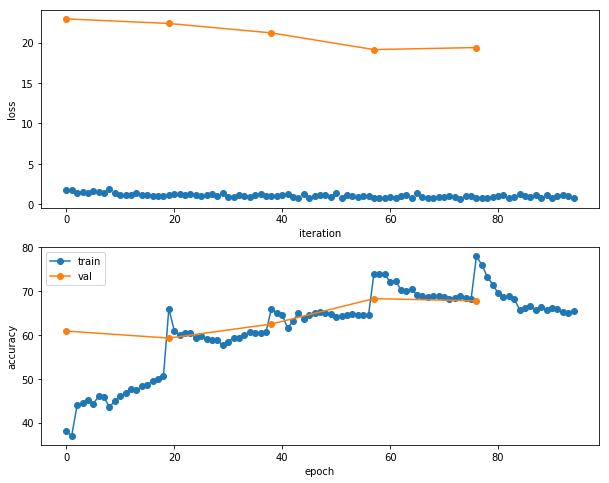

In [18]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(range(0, len(solver.val_loss_history) * 19, 19), solver.val_loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(range(0, len(solver.val_acc_history) * 19, 19), solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Filter visualization

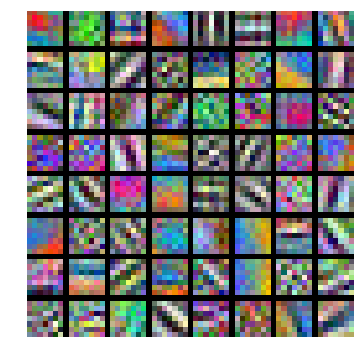

In [19]:
from src.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

# Testing the Model

In [21]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
for inputs, target in test_loader:
    inputs, targets = Variable(inputs), Variable(target)
    if model.is_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.type(torch.IntTensor).cpu()
    targets = targets.cpu()
    scores.extend((preds == targets).data.numpy())
    
print('Test set accuracy: %f' % np.mean(scores))

Test set accuracy: 0.659000


## Save the Model

When you are satisfied with your training, you can save the model.

In [ ]:
model.save("models/classification_cnn.model")